<a href="https://www.kaggle.com/code/natalyyakobov/time-series-analysis-stocks?scriptVersionId=190209297" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<img src="https://octodex.github.com/images/labtocat.png" width=200 height=200 />

# Let's make money!🤑🤑 Can we forecast stocks?
In this project, I dove headfirst into the wild world of **stock market analysis**📈, determined to **crack the code** of NVDA, MARA, and CLSK stocks. 


I pulled the data from stooq, set up the date range just right, and kicked off with some exploratory data analysis (EDA). Using cufflinks-plotly, I whipped up some **cool visualizations** to get a handle on stock returns, rolling averages, volatility, and Bollinger Bands. 

Then came the big showdown: I **predicted NVDA's close price** using the trusty SARIMAX model with a little help from auto ARIMA and then put it up against the high-tech LSTM neural network. 

Check this out!👩🏻‍💼

Imports

In [1]:
from pandas_datareader.data import DataReader
from pandas_datareader import wb
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Time Range
Determine the time range using explicit dates

In [2]:
start=datetime.datetime(2020, 1, 27)
end=datetime.datetime(2024,7,29)

# Read the Data
Pull out stocks data from stooq. You can also use the dataset from kaggle. 

In [3]:
NVDA= DataReader("NVDA", 'stooq', start, end).iloc[::-1] 
CLSK=DataReader("CLSK", 'stooq', start, end).iloc[::-1] 
MARA=DataReader("MARA", 'stooq', start, end).iloc[::-1] 

In [4]:
CLSK.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-27,5.2900,5.2900,5.000,5.1054,8735
2020-01-28,5.1715,5.1715,4.842,4.8420,7098
2020-01-29,5.0000,5.0000,4.760,4.7893,13068
2020-01-30,4.8500,4.8799,4.610,4.6900,8427
2020-01-31,4.6000,5.0919,4.600,4.6500,8244


In [5]:
tickers='NVDA CLSK MARA'.split()
stocks=pd.concat([NVDA, CLSK, MARA],axis=1,keys=tickers)
stocks.columns.names = ['Stock Ticker','Stock Info']
stocks

Stock Ticker       NVDA                                                 \
Stock Info         Open       High        Low      Close        Volume   
Date                                                                     
2020-01-27      5.93265    6.03274    5.78274    5.98148  4.723950e+08   
2020-01-28      6.04740    6.20731    5.99428    6.17484  3.122059e+08   
2020-01-29      6.16036    6.19663    6.07467    6.11462  2.604772e+08   
2020-01-30      6.01675    6.13479    5.96152    6.12121  2.916524e+08   
2020-01-31      6.07536    6.08735    5.84566    5.88749  3.718846e+08   
...                 ...        ...        ...        ...           ...   
2024-07-22    120.35000  124.07000  119.86000  123.54000  2.580689e+08   
2024-07-23    122.78000  124.69000  122.10000  122.59000  1.739110e+08   
2024-07-24    119.17000  119.95000  113.44000  114.25000  3.277769e+08   
2024-07-25    113.04000  116.63000  106.30000  112.28000  4.600670e+08   
2024-07-26    116.19000  116.20000  111.58000  113.06000  2.933991e+08   

Stock Ticker     CLSK                                        MARA          \
Stock Info       Open     High      Low    Close    Volume   Open    High   
Date                                                                        
2020-01-27     5.2900   5.2900   5.0000   5.1054      8735   0.91   1.000   
2020-01-28     5.1715   5.1715   4.8420   4.8420      7098   0.97   1.120   
2020-01-29     5.0000   5.0000   4.7600   4.7893     13068   1.04   1.040   
2020-01-30     4.8500   4.8799   4.6100   4.6900      8427   0.99   1.100   
2020-01-31     4.6000   5.0919   4.6000   4.6500      8244   1.10   1.100   
...               ...      ...      ...      ...       ...    ...     ...   
2024-07-22    18.0700  18.6100  17.0550  18.1300  30122919  25.03  25.560   
2024-07-23    17.9700  19.0400  17.3600  17.4500  31817601  23.50  23.570   
2024-07-24    17.6800  17.9400  16.5000  16.5700  32423197  22.03  22.590   
2024-07-25    16.2300  16.7291  15.5500  16.1800  25069373  20.25  21.265   
2024-07-26    16.9900  17.6650  16.6622  17.1200  26195284  21.57  22.140   

Stock Ticker                              
Stock Info        Low    Close    Volume  
Date                                      
2020-01-27     0.9100   0.9522    103080  
2020-01-28     0.9700   1.0100    510709  
2020-01-29     0.9700   0.9883     85163  
2020-01-30     0.9600   1.0700    238132  
2020-01-31     0.9905   1.0400    163452  
...               ...      ...       ...  
2024-07-22    23.3000  23.9500  48793639  
2024-07-23    21.5000  21.6500  54378411  
2024-07-24    20.6100  20.6700  36964220  
2024-07-25    19.9050  20.2800  37320555  
2024-07-26    20.8300  21.5700  43781943  

[1133 rows x 15 columns]

# Returns

Explore the returns. Returns basically mean how much money you made or lost on your investment over a certain period. It's usually shown as a percentage and is calculated by looking at how much the stock's price has changed. 

So, if you bought a stock at 100 USD and it went up to 110 USD, your return would be 10%. 

It's a way to see if your investment is paying off or not.

In [6]:
returns=pd.DataFrame()
for i in tickers:
    returns[i+' DailyReturn']=stocks[i]['Close'].pct_change()*100
returns.head()

,NVDA DailyReturn,CLSK DailyReturn,MARA DailyReturn
Date,,,
2020-01-27,NaN,NaN,NaN
2020-01-28,3.232645,-5.159243,6.070153
2020-01-29,-0.975248,-1.088393,-2.148515
2020-01-30,0.107774,-2.073372,8.266721
2020-01-31,-3.818199,-0.852878,-2.803738


In [7]:
returns.idxmin()

NVDA DailyReturn   2020-03-16
CLSK DailyReturn   2020-05-06
MARA DailyReturn   2021-11-15
dtype: datetime64[ns]

In [8]:
returns.idxmax()

NVDA DailyReturn   2023-05-25
CLSK DailyReturn   2020-05-05
MARA DailyReturn   2020-08-03
dtype: datetime64[ns]

In [9]:
returns.std()

NVDA DailyReturn    3.423828
CLSK DailyReturn    8.403224
MARA DailyReturn    8.988389
dtype: float64

# Exploratory Data Analysis

Imports

In [10]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()

In [11]:
stocks.xs(key='Close',axis=1,level=1).iplot(kind="line",title='Close Price')

In [12]:
window=20
stocks['NVDA','Rolling AVG']=NVDA['Close'].rolling(window).mean()
stocks['CLSK','Rolling AVG']=CLSK['Close'].rolling(window).mean()
stocks['MARA','Rolling AVG']=MARA['Close'].rolling(window).mean()

pd.concat([NVDA['Close'],CLSK['Close'],MARA['Close'],
           stocks['NVDA','Rolling AVG'],stocks['CLSK','Rolling AVG'],stocks['MARA','Rolling AVG']],axis=1,
          keys=('NVDA Close','CLSK Close','MARA Close',
                f'NVDA {window}day Avg',f'CLSK {window}day Avg',f'MARA {window}day Avg')).iplot()

In [13]:
stocks['NVDA','Rolling STD']=NVDA['Close'].rolling(window).std()
stocks['CLSK','Rolling STD']=CLSK['Close'].rolling(window).std()
stocks['MARA','Rolling STD']=MARA['Close'].rolling(window).std()

pd.concat([stocks['NVDA','Rolling STD'],
           stocks['CLSK','Rolling STD'],
           stocks['MARA','Rolling STD']],axis=1,
          keys=(f'NVDA {window}day std',f'CLSK {window}day std',f'MARA {window}day std')).iplot(title='Volatility')

Investigate a stock and forecast its close price using SARIMAX and Neural Networks

In [14]:
sto='NVDA'
qf = cf.QuantFig(stocks[sto],title=f'{sto} Bollinger Bands',legend='top',name=sto,up_color='green', down_color='red')
qf.add_bollinger_bands(periods=window, boll_std=2, colors=['#88511B','grey'], fill=True)
qf.add_volume(name='Volume',up_color='green', down_color='red')
qf.iplot()

In [15]:
col=f'{sto} DailyReturn'

returns[col].iplot(kind='bar',layout=go.Layout(title=col,yaxis=dict(title="Return, %")))

Autocorrelation Function and Partial Autocorrelation Function

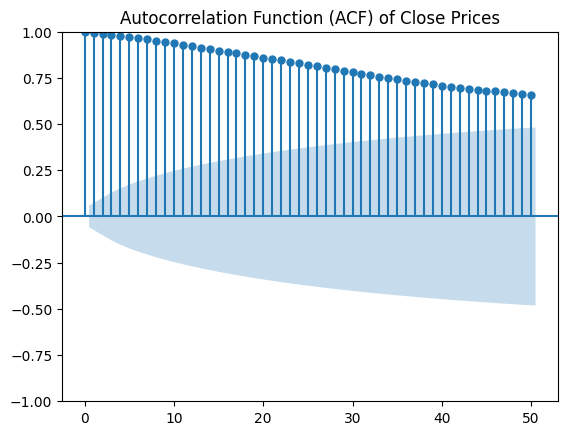

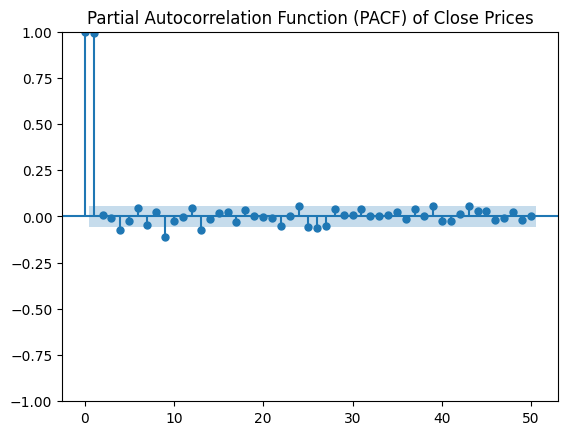

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot Autocorrelation Function (ACF)
plot_acf(stocks[sto,'Close'].dropna(), lags=50)
plt.title('Autocorrelation Function (ACF) of Close Prices')
plt.show()

# Plot Partial Autocorrelation Function (PACF) with the 'ywm' method
plot_pacf(stocks[sto,'Close'].dropna(), lags=50, method='ywm')
plt.title('Partial Autocorrelation Function (PACF) of Close Prices')
plt.show()

**Autocorrelation Function (ACF)**

ACF is a way to see if today's stock price is similar to the price from previous days. It tells us how today's price is related to prices from previous days (called lags).

High ACF Value at Lag 1: If you see a high value at lag 1, it means today's price is quite similar to yesterday's price.
High ACF Value at Lag 3: If you see a low value at lag 3, it means today's price is different from the price from three days ago, and so on.

The values in the ACF plot are gradually decreasing, it indicates a trend. The stock prices aren't random but follow some pattern over time.

**Partial Autocorrelation Function (PACF)**

PACF tries to find the direct relationship between today’s price and the price from a few days ago, ignoring the influence of the days in between.

High PACF Value at Lag 1: This means today's price is directly related to yesterday's price.
High PACF Value at Lag 3: If you see low spike at lag 3, it means today's price is not related to the price from three days ago, directly, without considering the influence of the price from one day ago.

If both ACF and PACF show high values at certain lags, it means past prices can help predict future prices to some extent.

The maximum valid forecast is a 2 days forecast. Longer-term predictions are less reliable

I'm gonna break down the stock price data into its underlying components: trend, seasonality, and noise. This helps me understand the overall direction the stock is moving in (the trend), any regular patterns that repeat over time (seasonality), and any random fluctuations (noise) that don't fit into the other two categories. This deeper insight allows for better analysis and more accurate predictions.

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(stocks[sto,'Close'], model='multiplicative', period=365)

# Create DataFrames for each component
observed = decomposition.observed.to_frame(name='Observed')
trend = decomposition.trend.to_frame(name='Trend')
seasonal = decomposition.seasonal.to_frame(name='Seasonal')
residual = decomposition.resid.to_frame(name='Residual')

fig = make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=('Observed', 'Trend', 'Seasonal', 'Residual'))

fig.add_trace(go.Scatter(x=observed.index, y=observed['Observed'], name='Observed'), row=1, col=1)
fig.add_trace(go.Scatter(x=trend.index, y=trend['Trend'], name='Trend'), row=2, col=1)
fig.add_trace(go.Scatter(x=seasonal.index, y=seasonal['Seasonal'], name='Seasonal'), row=3, col=1)
fig.add_trace(go.Scatter(x=residual.index, y=residual['Residual'], name='Residual'), row=4, col=1)

# Update layout
fig.update_layout(height=800, width=900, title_text="Seasonal Decomposition of Time Series")
fig.show()

In [18]:
display(residual.info())
a=residual.isnull().sum().values[0]
print(f"--------\nMissing data: {a} [{round(100*a/len(residual),0)}%] ")
print(f"--------\nDataframe's shape: {residual.shape}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1133 entries, 2020-01-27 to 2024-07-26
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Residual  769 non-null    float64
dtypes: float64(1)
memory usage: 17.7 KB


None

--------
Missing data: 364 [32.0%] 
--------
Dataframe's shape: (1133, 1)


Evaluate the seasonality decomposition with autocorrelation test on 20 lags. If the pvalue is lower than alpha 0.05 it means that my decomposition model is not performing well. 

In [19]:
from statsmodels.stats.diagnostic import acorr_ljungbox
# Performing the Ljung-Box test for multiple lags
lags = np.arange(1, 21)
residual.dropna(inplace=True)
test_results = acorr_ljungbox(residual, lags=lags, return_df=True)
# Preparing the data for plotting
df = pd.DataFrame({'Lag': lags, 'P-value': test_results['lb_pvalue']})
# Creating the plot with cufflinks
df.iplot(kind='scatter', x='Lag', y='P-value', mode='lines+markers', title='Ljung-Box Test P-values',
         xTitle='Lag', yTitle='P-value', asFigure=True).add_shape(
    dict(type='line', x0=1, x1=20, y0=0.05, y1=0.05, line=dict(color='Red', dash='dash'))
).show()

Significant autocorrelation in residuals suggests that the current model (seasonal decomposition) might not adequately capture all the variations in the data after accounting for seasonality and trend.

# Predict with SARIMAX model

In [20]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [21]:
from pmdarima import auto_arima

# Perform auto SARIMAX model selection
auto_model = auto_arima(stocks[sto,'Close'].dropna(), exogenous=None, seasonal=True, m=12)

# Extract the orders from the auto ARIMA model
order = auto_model.order
seasonal_order = auto_model.seasonal_order

# Fit the SARIMAX model using the identified orders
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(stocks[sto, 'Close'], order=order, seasonal_order=seasonal_order)
results = model.fit()
print(results.summary())

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74909D+00    |proj g|=  1.37473D-01

At iterate    5    f=  1.73884D+00    |proj g|=  5.08983D-04

At iterate   10    f=  1.73858D+00    |proj g|=  1.72120D-02

At iterate   15    f=  1.73771D+00    |proj g|=  9.83758D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     19     21      1     0     0   1.398D-05   1.738D+00
  F =   1.7377129252699619     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
        

Model Fit: The SARIMAX(2, 2, 1) model appears to **adequately capture the autocorrelation** in the data as indicated by the non-significant Ljung-Box test.

Normality Assumption: There is **evidence against the normality** assumption of residuals based on the Jarque-Bera test, suggesting potential issues with the model’s assumption about the distribution of errors.

Heteroskedasticity: Significant heteroskedasticity in residuals suggests that the model **may not fully account for changing variance over time**, which could impact the reliability of predictions.

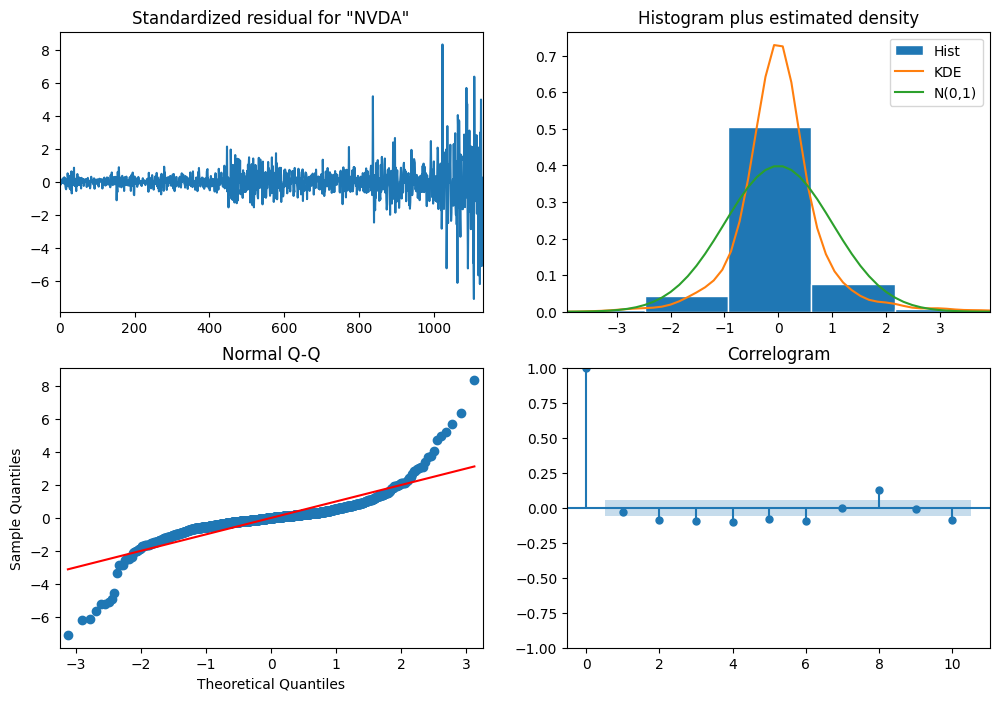

In [22]:
results.plot_diagnostics(figsize=(12, 8))
plt.show()

Residuals Plot:
Ideally, residuals should fluctuate around zero with no clear pattern or trend. Any systematic patterns might indicate that the model is missing some information or needs adjustment.

Autocorrelation Function (ACF) Plot:
Significant autocorrelation at certain lags suggests that the residuals are not independent. This could indicate that the model may benefit from including additional lagged terms or that the model order (p, q, P, Q) needs adjustment.

Histogram of Residuals:
Residuals should ideally follow a normal distribution centered around zero. Skewness or heavy tails in the histogram might suggest non-normality, indicating potential issues with the model’s assumptions or the need for a different error distribution.

QQ Plot (Quantile-Quantile Plot):
Points should approximately follow the diagonal line. Deviations from the line suggest departures from normality. Significant deviations might indicate that the residuals are not normally distributed, affecting the reliability of statistical inference.

If the residuals plot shows random scattering around zero, ACF plot shows no significant autocorrelation, histogram shows a bell-shaped curve, and QQ plot shows points close to the diagonal line, it indicates that the SARIMAX model adequately captures the patterns in the data.

In [23]:
# Define train and test size
train_size = int(len(stocks[sto, 'Close']) * 0.98)
train, test = stocks[sto, 'Close'][:train_size], stocks[sto, 'Close'][train_size:]

# Fit the SARIMAX model on training data
train_model = SARIMAX(train, order=(2, 2, 1), seasonal_order=(0, 0, 0, 0))
train_results = train_model.fit()

# Forecast the test data
forecast = train_results.get_forecast(steps=len(test))
forecasted_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Set forecast index to match the test period
forecasted_values.index = test.index
confidence_intervals.index = test.index

# Plot forcast
pd.concat([train,test,forecasted_values],axis=1,keys=['Train','Test','Forcast']).iplot()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64973D+00    |proj g|=  9.71121D-02

At iterate    5    f=  1.59580D+00    |proj g|=  1.20843D-01

At iterate   10    f=  1.57983D+00    |proj g|=  2.87371D-03

At iterate   15    f=  1.57913D+00    |proj g|=  1.15946D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   4.072D-07   1.579D+00
  F =   1.5791295311570590     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



# Evaluate the SARIMAX prediction

In [24]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
# Calculate performance metrics
mae = round(mean_absolute_error(test, forecasted_values),3)
rmse1 = round(mean_squared_error(test, forecasted_values,squared=False),3)

print(f'MAE: {mae}')
print(f'RMSE: {rmse1}')

MAE: 6.506
RMSE: 7.568


MAE (Mean Absolute Error): It represents the average absolute difference between the forecasted values and the actual values. A lower MAE indicates better accuracy.


RMSE (Root Mean Square Error): It represents the square root of the average squared differences between the forecasted values and the actual values. It gives more weight to larger errors. A lower RMSE also indicates better accuracy.

These values suggest that, on average, the model's predictions are off by around 6 units, and larger errors are penalized more heavily in the RMSE, with an average deviation of about 7 units.

# Predict with LSTM model

Imports

In [25]:
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.callbacks import EarlyStopping

2024-07-28 22:17:22.156336: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 22:17:22.156482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 22:17:22.299602: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Use only the close price

In [26]:
data=pd.DataFrame(stocks[sto,'Close'].dropna())
print(data.shape)
data.head()

(1133, 1)


,NVDA
,Close
Date,
2020-01-27,5.98148
2020-01-28,6.17484
2020-01-29,6.11462
2020-01-30,6.12121
2020-01-31,5.88749


Creating sequences prepares the time series data in a format that LSTM model can effectively learn from, enabling accurate predictions of future values based on past observations. The observation window I chose is 60 days.

In [27]:
# Scale the data
scaler=MinMaxScaler() 
scaled_data = scaler.fit_transform(data)

# Define the training data length
train_data_len = int(np.ceil(len(scaled_data) * 0.8))

seq_length = 40

# Split the data into training and testing sets
train_data = scaled_data[:train_data_len, :]
test_data = scaled_data[train_data_len - seq_length:, :]

# Create the training data sequences
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(seq_length, len(data)):
        sequences.append(data[i-seq_length:i, 0])
        labels.append(data[i, 0])
    return np.array(sequences), np.array(labels)

x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)

# Reshape the data to fit the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Build the Long-Short Term Memory (LSTM) Model

In [28]:
model = Sequential()
model.add(Input(shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=300, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 2/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.5359e-04 - val_loss: 0.0022
Epoch 3/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 2.0630e-04 - val_loss: 0.0018
Epoch 4/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.5075e-04 - val_loss: 0.0022
Epoch 5/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.5551e-04 - val_loss: 0.0015
Epoch 6/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.5956e-04 - val_loss: 0.0016
Epoch 7/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.4629e-04 - val_loss: 0.0011
Epoch 8/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.6675e-04 - val_loss: 0.0011
Epoch 9/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.0343e-04 - val_loss: 0.0018
Epoch 10/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.1933e-04 - val_loss: 0.0010
Epoch 11/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.0969e-04 - val_loss: 0.0027
Epoch 12/300

# Evaluate the LSTM prediction 

In [29]:
# Make predictions
pred_LSTM = model.predict(x_test)
pred_LSTM = scaler.inverse_transform(pred_LSTM)

# Calculate RMSE
rmse2 = round(mean_squared_error(y_test, pred_LSTM, squared=False),3)

print(f'Root Mean Squared Error: {rmse2}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Root Mean Squared Error: 77.178


That's a high error rate. The LSTM performed poorly as a predictive model in this particular task.

In [30]:
# Plot the data
train = stocks[sto]['Close'][:train_data_len]
valid = stocks[sto]['Close'][train_data_len:].copy() 
pred=pd.Series(pred_LSTM.flatten(),index=valid.index,name='Pred')
pd.concat([train, valid, pred] ,axis=1 ,keys=['Train','Valid','Predicted']).iplot()

# Conclusion

In [31]:
print(f'SARIMAX RMSE:  {rmse1}\n LSTM RMSE:  {rmse2}')

SARIMAX RMSE:  7.568
 LSTM RMSE:  77.178


To conclude, my exploration into time-series analysis has been enlightening, particularly in understanding the complexities of stock market prediction. While SARIMAX models are commonly used for forecasting, I've realized their effectiveness can vary significantly depending on the presence of seasonal patterns, which stocks may not always exhibit clearly.

In this case, the forecast is most accurate for predicting only the next 2 days.

I suspect that certain stocks might align better with SARIMAX modeling than others due to their inherent seasonal behaviors and trends. Throughout this process, I've developed a preference for interactive cufflinks-plotly plots, especially when visualizing and analyzing stock market data.


It seems like the LSTM model may have learned too much from the training data, making its predictions less accurate when faced with new data (high RMSE of 75). To improve its forecasting ability, I could try using more diverse data, simplifying the model, and fine-tuning its settings. This might help it better understand the underlying trends and make more reliable predictions in the future.

Upvote me if this notebook helped you get a better understanding of stocks' analysis or if you enjoyed the visualizations. ❤️❤️❤️